
# TP CNN, part 3 : super-resolution

Author : Alasdair Newson
alasdair.newson@telecom-paris.fr
 
## Objective:

We want to implement a Convolutional Neural Network (CNN) to do image super-resolution.

## Image super-resolution:

The super-resolution problem can be summarised as follows. We have an image as an input, which is defined over a grid $\{0,1,\dots, m-1\} \times \{0,1,\dots, n-1\}$. We define a factor $\delta$, by which we upsample the image. The output of the super-resolution is an image defined on the grid $\{0,\frac{1}{\delta},\dots, m-1\} \times \{0,\frac{1}{\delta},\dots, n-1\}$.

## Model

In this part of the TP, you have complete freedom to create any model you want, as long as the input is an image, and the output is also an image of size $\delta m \times \delta n$. You will have to choose the architecture and loss which seems reasonable to you.

To help you, here is a function to upsample images in neural networks :

- ```from tensorflow.keras.layers import UpSampling2D```

Of course, you can use any upsampling layer you wish. 

## Dataset

We will be using the mnist dataset for this part. This is to ensure that you can obtain good results. The input data should be the subsampled version of the mnist images, subsampled by taking one out of every $\delta$ pixels. The output data should be the normal-resolution mnist images.

__IMPORTANT NOTES:__
- Think carefully about what the training data and labels are in this case, and create them accordingly
- We will use ```n_max=5000``` to limit the number of datapoints (as in part 1) to go faster
- We set $\delta$ to 2 in this TP, because it is not too difficult to create a network that works with this factor. If you change it, it might be more difficult to create a satisfactory network.

# Your task:
You have to load the mnist data (see the first part of the TP), create the model, train it, and evaluate and display the results.

We have created a function ```super_res_interpolate```, which carries out super-resolution using basic interpolation (bilinear or bicubic), with which you can compare your results visually and numerically.



In [73]:

# # Load packages

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import optimizers, regularizers
from scipy import interpolate
print(tf.keras.__version__)

2.7.0


This next cell is the only code you are given to carry out the TP. This
function carries out a bilinear upsampling, with which you can compare your super-resolution. This function is __not__ supposed to be used by you in your network.

In [74]:
# choice of the interpolation method
interp_method = 'linear'
# upsampling factor
delta = 2
# the maximum number of data to take from mnist (to go a bit faster)
n_max = 5000

# upsample by a factor of delta
# by definition, the new grid has a step size of 1/delta
def super_res_interpolate(imgs_in,delta,interp_method = 'linear'):
	imgs_out = tf.image.resize( tf.constant(imgs_in),\
		[delta*imgs_in.shape[1],delta*imgs_in.shape[2]], method='bilinear').numpy()

	return(imgs_out)


## Create your super-resolution network

The rest is up to you ! Import the data, format it (you can use the first part of the TP as help), create your network, train it, and compare the results with ```super_res_interpolate```.

Your network should be able to achieve about $80\%$ accuracy.

__Note__ you can obviously create as many cells as you like in your work.

#I. MNIST data set



##Load Data
In this section, we work with MNIST dataset.

First we load data and preprocess them.


In [75]:
from keras.datasets import mnist
(X_train_mnist, Y_train_mnist_scalar),(X_test_mnist,Y_test_mnist_scalar) = mnist.load_data()

#Take size of images: 
img_rows_origin, img_cols_origin = X_train_mnist.shape[1],X_train_mnist.shape[2]
#number of channels:
nb_channels = 1

X_train_mnist = X_train_mnist.reshape(X_train_mnist.shape[0], img_rows_origin, img_cols_origin, nb_channels)
X_test_mnist = X_test_mnist.reshape(X_test_mnist.shape[0], img_rows_origin, img_cols_origin, nb_channels)

n_max = 5000
#Limit to 5000 images each set
# X_train, X_test will be used in training model
X_train = X_train_mnist[0:n_max,:,:]
X_test = X_test_mnist[0:n_max,:,:]

#Image data to float type and normalize:

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255.
X_test = X_test/255.

#print image size
print(X_train.shape)


(5000, 28, 28, 1)


Now we will distort images on both sets. We do it by rescale image size to $\frac{1}{\delta}$ (here $\frac{1}{2}$). Image quality will be reduced due to  information loss in downscaling.


Here we downscale image by picking even rows, even columns of image and eliminate odd rows & odd columns.


There is another way by using tf.image.resize()

Resize function (picking even rows and columns):

In [76]:
def resize_image(X,delta):
  return X[:,::delta,::delta,:]

In [77]:
#Set delta:
delta = 2

#Now our output data to train model will be the original image,
Y_train = X_train
Y_test = X_test

#Resize X_train, X_test to new size in order to get input data of the model:
X_train = resize_image(X_train,delta)
X_test = resize_image(X_test,delta)

print(X_train.shape)
print(Y_train.shape)

(5000, 14, 14, 1)
(5000, 28, 28, 1)


So the model will transform a (14,14,1) image to a (28,28,1) image

##Observe image before and after downscaled



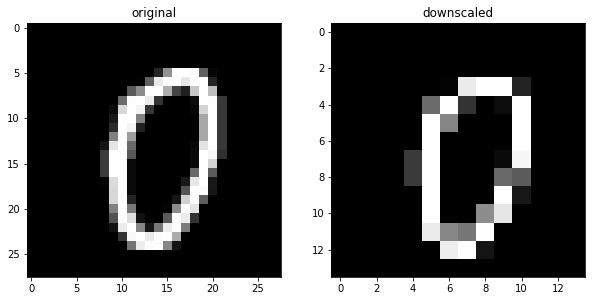

In [78]:
plt.figure(figsize = (10,6))
plt.subplot(121)
plt.imshow(Y_train[1000,:,:,0],cmap='gray')
plt.title("original")
plt.subplot(122)
plt.imshow(X_train[1000,:,:,0],cmap = 'gray')
plt.title("downscaled");

##Model and parameters

We will build a model with layers below:
- A convolutional layer of size(3,3), 28 filters, padding "SAME", activation "ReLU", kernel initializer "glorot_uniform"
- A convolutional layer of size(4,4), 64 filters, padding "SAME", activation "ReLU", kernel initializer "glorot_uniform"
- UpSampling2D of size (2,2)
- A convolutional layer of size(3,3), 64 filters, padding "SAME", activation "ReLU", kernel initializer "glorot_uniform"
- A convolutional layer of size(3,3), 1 filters, padding "SAME", activation "ReLU", kernel initializer "glorot_uniform"

Learning_rate = 0.003

Loss we use here is Mean Squared Error (MSE)

##Build Model

Shape of train and test sets.

In [79]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5000, 14, 14, 1)
(5000, 28, 28, 1)
(5000, 14, 14, 1)
(5000, 28, 28, 1)


In [80]:
model = Sequential()
model.add(Conv2D(filters= 28, kernel_size = (3,3), padding = 'SAME', use_bias = True,input_shape = (14,14,1),kernel_initializer='glorot_uniform', activation = 'relu' ))
model.add(Conv2D(filters = 64, kernel_size=(4,4), padding = 'SAME', use_bias = True, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = 'SAME', use_bias = True, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Conv2D(filters = 1, kernel_size = (3,3), padding = 'SAME', use_bias = True, kernel_initializer = 'glorot_uniform', activation = 'relu'))


In [81]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003)
model.compile(loss = 'mean_squared_error',optimizer = optimizer, metrics = ['accuracy'] )
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 28)        280       
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        28736     
                                                                 
 up_sampling2d_5 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 1)         577       
                                                                 
Total params: 66,521
Trainable params: 66,521
Non-trainable params: 0
__________________________________________________

In [82]:
model.fit(X_train,Y_train, validation_data = (X_test,Y_test), epochs = 15, shuffle = True)

Epoch 1/15
157/157 [==============================] - 4s 21ms/step - loss: 0.0090 - accuracy: 0.8140 - val_loss: 0.0060 - val_accuracy: 0.8229
Epoch 2/15
157/157 [==============================] - 3s 19ms/step - loss: 0.0053 - accuracy: 0.8145 - val_loss: 0.0051 - val_accuracy: 0.8234
Epoch 3/15
157/157 [==============================] - 3s 19ms/step - loss: 0.0049 - accuracy: 0.8146 - val_loss: 0.0050 - val_accuracy: 0.8232
Epoch 4/15
157/157 [==============================] - 3s 19ms/step - loss: 0.0047 - accuracy: 0.8147 - val_loss: 0.0047 - val_accuracy: 0.8234
Epoch 5/15
157/157 [==============================] - 3s 19ms/step - loss: 0.0046 - accuracy: 0.8147 - val_loss: 0.0048 - val_accuracy: 0.8233
Epoch 6/15
157/157 [==============================] - 2s 15ms/step - loss: 0.0045 - accuracy: 0.8147 - val_loss: 0.0045 - val_accuracy: 0.8235
Epoch 7/15
157/157 [==============================] - 3s 19ms/step - loss: 0.0044 - accuracy: 0.8147 - val_loss: 0.0045 - val_accuracy: 0.8236

In [83]:
score = model.evaluate(X_test,Y_test, verbose = False)
print(score)
print('Test_lost: ', score[0])
print('Test accuracy:', score[1])

[0.00429694727063179, 0.8234211802482605]
Test_lost:  0.00429694727063179
Test accuracy: 0.8234211802482605


In [84]:
print("Our model got accuracy rate of " + str(score[1]*100).split('.')[0] + "%")

Our model got accuracy rate of 82%


##Compare network result with ```super_res_interpolate```

Now we will pick a set of 5 images in MNIST who are not in training or test dataset that we used.
Then we will visually compare result from network and function ```super_res_interpolate```

In [85]:
X_train.shape

(5000, 14, 14, 1)

In [86]:
#Pick data

images_test = X_train_mnist[10000:10005,:,:,:]

#Downscale:
images_down_scaled = resize_image(images_test,delta)

#result from super_res_interpolate:
img_after_SRI = super_res_interpolate(images_down_scaled,delta)

#result from network:

img_after_network = model.predict(images_down_scaled)

print(img_after_SRI.shape)
print(img_after_network.shape)

(5, 28, 28, 1)
(5, 28, 28, 1)


Visual result

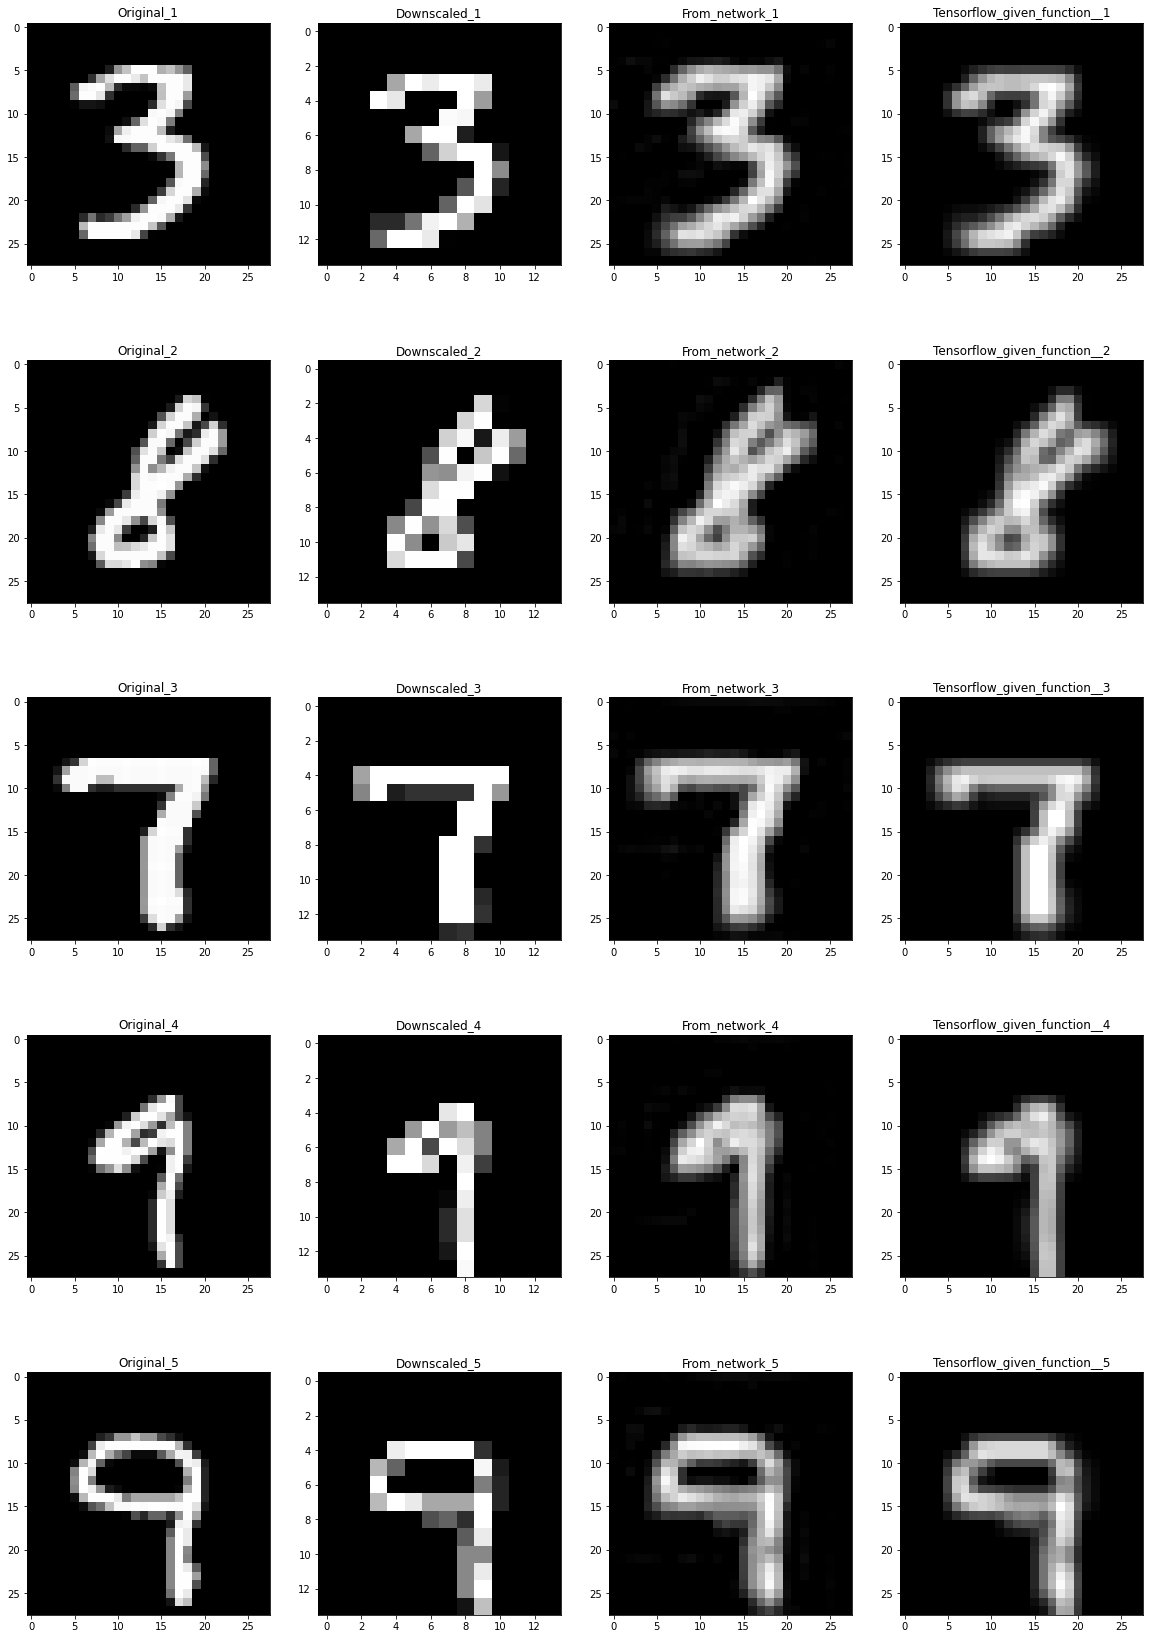

In [87]:
plt.figure(figsize = (20,30))
for i in range(5):
  plt.subplot(5,4,i*4+1)
  plt.imshow(images_test[i,:,:,0],cmap = "gray")
  plt.title("Original_{}".format(i+1))
  plt.subplot(5,4,i*4+2)
  plt.imshow(images_down_scaled[i,:,:,0],cmap = "gray")
  plt.title("Downscaled_{}".format(i+1))
  plt.subplot(5,4,i*4+3)
  plt.imshow(img_after_network[i,:,:,0],cmap = "gray")
  plt.title("From_network_{}".format(i+1))
  plt.subplot(5,4,i*4+4)
  plt.imshow(img_after_SRI[i,:,:,0],cmap = "gray")
  plt.title("Tensorflow_given_function__{}".format(i+1))

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Importing MNIST correctly (correctly formatting the data) : 1 point
- 2) Creating a model which makes sense (correct input/output sizes) : 1 point
- 3) Training and achieving good results  : 2 points. 1 point if the learning increases but does not reach around $80\%$, 2 points if the learning reaches around $80\%$
- 4) Display a visual comparison of your network with ```super_res_interpolate``` for several examples

Total over 5 points.


#Work on Cifar10

In [88]:
from tensorflow.keras.datasets import cifar10
(X_train_cifar, Y_train_cifar_scalar),(X_test_cifar,Y_test_cifar_scalar) = cifar10.load_data()

print("Train data shape : ", X_train_cifar.shape)
print("Test data shape : ", X_test_cifar.shape)

Train data shape :  (50000, 32, 32, 3)
Test data shape :  (10000, 32, 32, 3)


In [89]:
# input image dimensions
img_rows, img_cols, nb_channels = 32, 32, 3
nb_classes = 10

X_train = X_train_cifar[0:2000,:,:,:]
X_test = X_test_cifar[0:2000,:,:,:]

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.


print('X_train shape:', X_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (2000, 32, 32, 3)
There is 2000 train data
32 32 3


Downscaling

Here use downscale images by using tf.image.resize()

In [90]:
delta = 2
reduced_size = (int(img_rows/2),int(img_cols/2))
Y_train = X_train
Y_test = X_test

X_train = tf.image.resize(X_train,reduced_size)
X_test = tf.image.resize(X_test,reduced_size)

print(X_train.shape)
print(Y_train.shape)

(2000, 16, 16, 3)
(2000, 32, 32, 3)


We can take a look at downscaled image

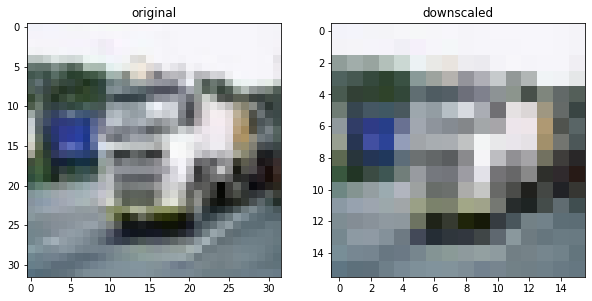

In [91]:
plt.figure(figsize = (10,6))
plt.subplot(121)
plt.imshow(Y_train[1000,:,:,:],cmap='gray')
plt.title("original")
plt.subplot(122)
plt.imshow(X_train[1000,:,:,:],cmap = 'gray')
plt.title("downscaled");

In [92]:
model = Sequential()
model.add(Conv2D(filters= 28, kernel_size = (3,3), padding = 'SAME', use_bias = True,input_shape = (16,16,3),kernel_initializer='glorot_uniform', activation = 'relu' ))
model.add(Conv2D(filters = 64, kernel_size=(4,4), padding = 'SAME', use_bias = True, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = 'SAME', use_bias = True, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Conv2D(filters = 3, kernel_size = (3,3), padding = 'SAME', use_bias = True, kernel_initializer = 'glorot_uniform', activation = 'relu'))

In [93]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003)
model.compile(loss = 'mean_squared_error',optimizer = optimizer, metrics = ['accuracy'] )
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 16, 16, 28)        784       
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        28736     
                                                                 
 up_sampling2d_6 (UpSampling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 3)         1731      
                                                                 
Total params: 68,179
Trainable params: 68,179
Non-trainable params: 0
__________________________________________________

In [94]:
model.fit(X_train,Y_train, validation_data = (X_test,Y_test), epochs = 10, shuffle = True)

Epoch 1/10
63/63 [==============================] - 2s 24ms/step - loss: 0.0182 - accuracy: 0.5577 - val_loss: 0.0048 - val_accuracy: 0.7261
Epoch 2/10
63/63 [==============================] - 1s 19ms/step - loss: 0.0041 - accuracy: 0.7678 - val_loss: 0.0037 - val_accuracy: 0.7865
Epoch 3/10
63/63 [==============================] - 2s 24ms/step - loss: 0.0034 - accuracy: 0.7882 - val_loss: 0.0033 - val_accuracy: 0.7869
Epoch 4/10
63/63 [==============================] - 1s 24ms/step - loss: 0.0030 - accuracy: 0.8165 - val_loss: 0.0028 - val_accuracy: 0.8271
Epoch 5/10
63/63 [==============================] - 1s 19ms/step - loss: 0.0029 - accuracy: 0.8121 - val_loss: 0.0026 - val_accuracy: 0.8308
Epoch 6/10
63/63 [==============================] - 1s 19ms/step - loss: 0.0031 - accuracy: 0.8083 - val_loss: 0.0027 - val_accuracy: 0.8015
Epoch 7/10
63/63 [==============================] - 1s 19ms/step - loss: 0.0027 - accuracy: 0.8338 - val_loss: 0.0029 - val_accuracy: 0.8092
Epoch 8/10
63

In [95]:
score = model.evaluate(X_test,Y_test, verbose = False)
print(score)
print('Test_lost: ', score[0])
print('Test accuracy:', score[1])

[0.0024586129002273083, 0.8576103448867798]
Test_lost:  0.0024586129002273083
Test accuracy: 0.8576103448867798


In [96]:
# choice of the interpolation method
interp_method = 'linear'
# upsampling factor
delta = 2
# the maximum number of data to take from cifar10 (to go a bit faster)
n_max = 5000

# upsample by a factor of delta
# by definition, the new grid has a step size of 1/delta
def super_res_interpolate(imgs_in,delta,interp_method = 'linear'):
	imgs_out = tf.image.resize( tf.constant(imgs_in),\
		[delta*imgs_in.shape[1],delta*imgs_in.shape[2]], method='bilinear').numpy()

	return(imgs_out)


#Pick data

images_ori = X_train_cifar[20000:20005,:,:,:]

#Downscale:
images_test = tf.image.resize(images_ori,reduced_size).numpy()

#result from super_res_interpolate:
img_after_SRI = super_res_interpolate(images_test,delta)

#result from network:

img_after_network = model.predict(images_test)

print(img_after_SRI.shape)
print(img_after_network.shape)

(5, 32, 32, 3)
(5, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


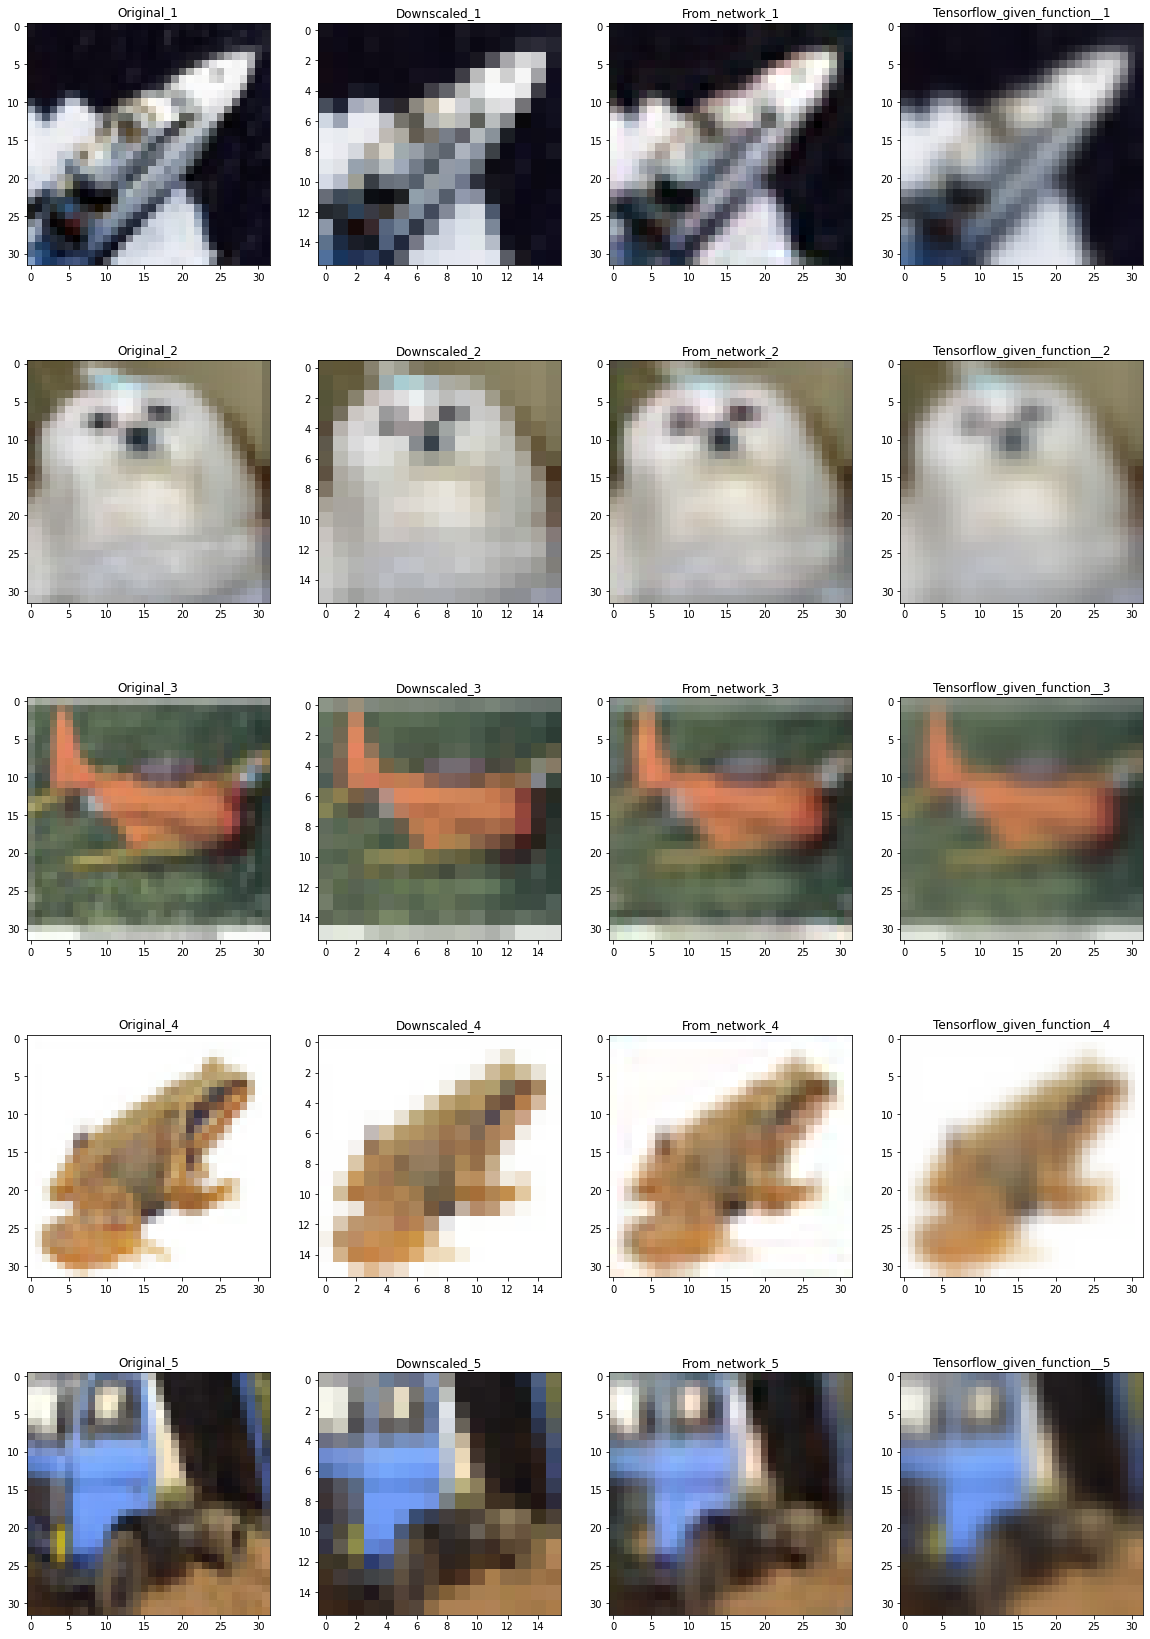

In [97]:
plt.figure(figsize = (20,30))
for i in range(5):
  plt.subplot(5,4,i*4+1)
  plt.imshow(images_ori[i,:,:,:]/255.);
  plt.title("Original_{}".format(i+1))
  plt.subplot(5,4,i*4+2)
  plt.imshow(images_test[i,:,:,:]/255.);
  plt.title("Downscaled_{}".format(i+1))
  plt.subplot(5,4,i*4+3)
  plt.imshow(img_after_network[i,:,:,:]/255.);
  plt.title("From_network_{}".format(i+1))
  plt.subplot(5,4,i*4+4)
  plt.imshow(img_after_SRI[i,:,:,:]/255.);
  plt.title("Tensorflow_given_function__{}".format(i+1))